## Logistic Regression Implementation on (scaled) non-reduced dataset (baseline model)

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Take sample for (initial) tests

In [4]:
#df_scaled_sample = df_scaled.sample(n=500, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [6]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [7]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=23)

In [8]:
predictions = model.predict(X_test)

Metrics for LR_baseline_untuned:
Accuracy: 0.7418
Weighted F1: 0.7413
Weighted Precision: 0.7421
Weighted Recall: 0.7418
Macro-Averaged Precision: 0.7423
Macro-Averaged Recall: 0.7404
F1: [0.75788816 0.72351052]
Precision: [0.73738602 0.74723655]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.70      0.72      1446

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


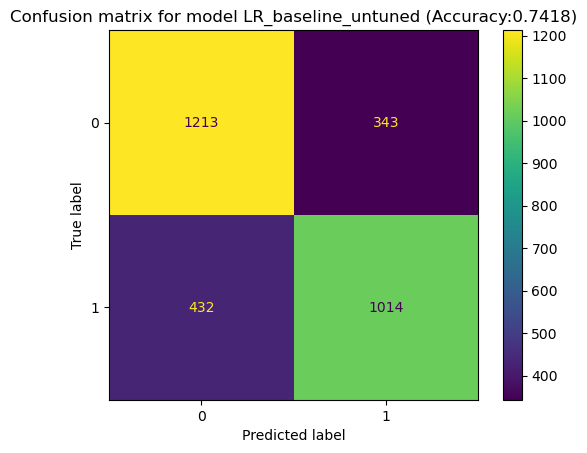

In [9]:
model_metrics = calculate_metrics('LR_baseline_untuned', y_test, predictions)

In [10]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [11]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [12]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.7468354430379747


Results of best models Grid Search CV

In [13]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                                params  mean_test_score
165  {'C': 100, 'max_iter': 5000, 'penalty': 'l1', ...         0.737443
145  {'C': 100, 'max_iter': 100, 'penalty': 'l1', '...         0.737443
161  {'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...         0.737443
149  {'C': 100, 'max_iter': 200, 'penalty': 'l1', '...         0.737443
157  {'C': 100, 'max_iter': 100, 'penalty': 'l1', '...         0.737443


Metrics for LR_baseline_CV1_best:
Accuracy: 0.7468
Weighted F1: 0.7463
Weighted Precision: 0.7472
Weighted Recall: 0.7468
Macro-Averaged Precision: 0.7474
Macro-Averaged Recall: 0.7454
F1: [0.76264834 0.72876517]
Precision: [0.7417983  0.75294985]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


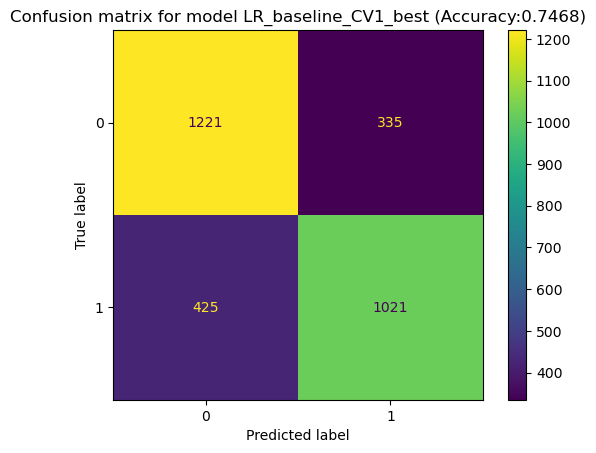

In [14]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_baseline_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy with Stratified K-Fold: 0.7465023317788141


Results of the best model 

In [16]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7465023317788141


Results of best models Grid Search CV

In [17]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
124  {'C': 10, 'max_iter': 500, 'penalty': 'l1', 's...         0.737693
128  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...         0.737693
136  {'C': 10, 'max_iter': 5000, 'penalty': 'l1', '...         0.737693
149  {'C': 100, 'max_iter': 200, 'penalty': 'l1', '...         0.737693
116  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...         0.737693


Metrics for LR_baseline_skf_best:
Accuracy: 0.7465
Weighted F1: 0.7460
Weighted Precision: 0.7468
Weighted Recall: 0.7465
Macro-Averaged Precision: 0.7471
Macro-Averaged Recall: 0.7450
F1: [0.76241024 0.72831132]
Precision: [0.74134791 0.75276753]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


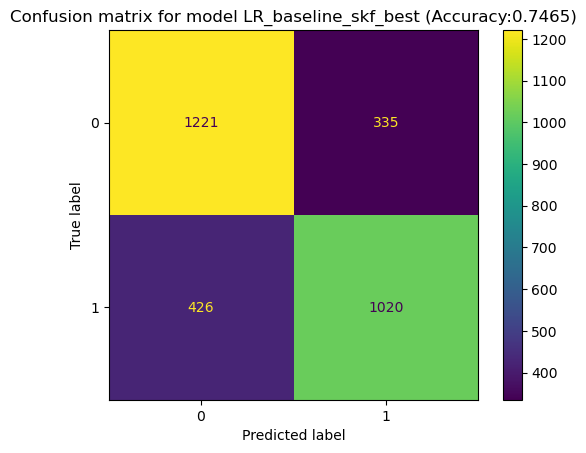

In [18]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_baseline_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [19]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [20]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 21:52:34,946] A new study created in memory with name: no-name-937e92cb-3fc6-4eac-9632-d9a8ba64eeeb
[I 2024-06-09 21:52:35,008] Trial 0 finished with value: 0.7438374417055297 and parameters: {'penalty': 'l2', 'C': 1.9786969219723538, 'max_iter': 354, 'solver': 'saga'}. Best is trial 0 with value: 0.7438374417055297.
[I 2024-06-09 21:52:35,065] Trial 1 finished with value: 0.7425049966688874 and parameters: {'penalty': 'l2', 'C': 0.7147547361025184, 'max_iter': 471, 'solver': 'saga'}. Best is trial 0 with value: 0.7438374417055297.
[I 2024-06-09 21:52:35,441] Trial 2 finished with value: 0.7455029980013325 and parameters: {'penalty': 'l1', 'C': 0.5871453092844535, 'max_iter': 981, 'solver': 'liblinear'}. Best is trial 2 with value: 0.7455029980013325.
[I 2024-06-09 21:52:35,861] Trial 3 finished with value: 0.7468354430379747 and parameters: {'penalty': 'l1', 'C': 2.933587303300426, 'max_iter': 664, 'solver': 'liblinear'}. Best is trial 3 with value: 0.7468354430379747.
[

Best Hyperparameters: {'penalty': 'l1', 'C': 1.0653730304965756, 'max_iter': 963, 'solver': 'saga'}
Best Accuracy: 0.7475016655562958


In [21]:
# Get best trials
trials_OTP1 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP1 = trials_OTP1.sort_values(by='value', ascending=False).head(10)
top_trials_OTP1

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_penalty,params_solver,state
152,152,0.747502,2024-06-09 21:52:52.433406,2024-06-09 21:52:52.518878,0 days 00:00:00.085472,1.065373,963,l1,saga,COMPLETE
70,70,0.747169,2024-06-09 21:52:43.118070,2024-06-09 21:52:43.207202,0 days 00:00:00.089132,0.819648,681,l1,saga,COMPLETE
156,156,0.747169,2024-06-09 21:52:52.999212,2024-06-09 21:52:53.071039,0 days 00:00:00.071827,1.174918,768,l1,saga,COMPLETE
190,190,0.747169,2024-06-09 21:52:56.701262,2024-06-09 21:52:57.105992,0 days 00:00:00.404730,1.452141,433,l1,liblinear,COMPLETE
68,68,0.747169,2024-06-09 21:52:42.947573,2024-06-09 21:52:43.047949,0 days 00:00:00.100376,0.760989,545,l1,saga,COMPLETE
150,150,0.747169,2024-06-09 21:52:51.926163,2024-06-09 21:52:52.319370,0 days 00:00:00.393207,1.514804,518,l1,liblinear,COMPLETE
118,118,0.747169,2024-06-09 21:52:48.786276,2024-06-09 21:52:48.864455,0 days 00:00:00.078179,0.804828,795,l1,saga,COMPLETE
20,20,0.747169,2024-06-09 21:52:37.657820,2024-06-09 21:52:37.732303,0 days 00:00:00.074483,0.761548,457,l1,saga,COMPLETE
135,135,0.746835,2024-06-09 21:52:50.375340,2024-06-09 21:52:50.713806,0 days 00:00:00.338466,3.845877,133,l1,liblinear,COMPLETE
81,81,0.746835,2024-06-09 21:52:44.173078,2024-06-09 21:52:44.542146,0 days 00:00:00.369068,3.424618,301,l1,liblinear,COMPLETE


Metrics for LR_baseline_OPT1_best:
Accuracy: 0.7475
Weighted F1: 0.7469
Weighted Precision: 0.7479
Weighted Recall: 0.7475
Macro-Averaged Precision: 0.7482
Macro-Averaged Recall: 0.7460
F1: [0.76371571 0.72889843]
Precision: [0.74152542 0.75481481]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.79      0.76      1556
     Class 1       0.75      0.70      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


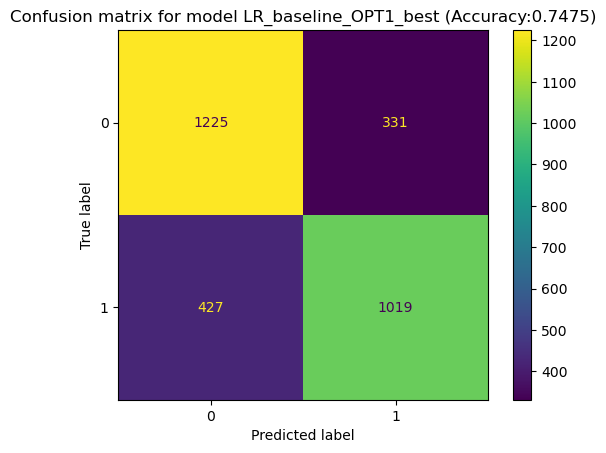

In [22]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_baseline_OPT1_best', y_test, predictions_opt1)])

In [23]:
study.best_params

{'penalty': 'l1', 'C': 1.0653730304965756, 'max_iter': 963, 'solver': 'saga'}

In [24]:
optuna.visualization.plot_optimization_history(study)

In [25]:
optuna.visualization.plot_parallel_coordinate(study)

In [26]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [27]:
optuna.visualization.plot_param_importances(study)

In [28]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [29]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [30]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 21:52:59,104] A new study created in memory with name: no-name-9ba9c42e-0c72-4c30-a77e-c47a0bfdbdb1
[I 2024-06-09 21:52:59,164] Trial 0 finished with value: 0.7468354430379747 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-09 21:52:59,240] Trial 1 finished with value: 0.7415056628914057 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 0.07659165484895042, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-09 21:52:59,311] Trial 2 finished with value: 0.7411725516322452 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 0.37133840345513924, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-09 21:52:59,373] Trial 3 finished with value: 0.7251832111925383 and parameters: {'l1_ratio': 0.

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.7468354430379747


In [31]:
# Get best trials
trials_OTP2 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP2 = trials_OTP2.sort_values(by='value', ascending=False).head(10)
top_trials_OTP2

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.746835,2024-06-09 21:52:59.105815,2024-06-09 21:52:59.164856,0 days 00:00:00.059041,61.355064,0.517298,789,elasticnet,saga,COMPLETE
16,16,0.746835,2024-06-09 21:53:00.354599,2024-06-09 21:53:00.444880,0 days 00:00:00.090281,66.521091,0.483055,912,elasticnet,saga,COMPLETE
113,113,0.746835,2024-06-09 21:53:07.489339,2024-06-09 21:53:07.563783,0 days 00:00:00.074444,95.651405,0.086517,668,elasticnet,saga,COMPLETE
65,65,0.746835,2024-06-09 21:53:03.866481,2024-06-09 21:53:03.946753,0 days 00:00:00.080272,91.867857,0.480687,544,elasticnet,saga,COMPLETE
151,151,0.746835,2024-06-09 21:53:10.182628,2024-06-09 21:53:10.250415,0 days 00:00:00.067787,54.003560,0.857694,548,elasticnet,saga,COMPLETE
46,46,0.746835,2024-06-09 21:53:02.532278,2024-06-09 21:53:02.594719,0 days 00:00:00.062441,1.217760,0.760956,210,elasticnet,saga,COMPLETE
159,159,0.746835,2024-06-09 21:53:10.733231,2024-06-09 21:53:10.811589,0 days 00:00:00.078358,1.416447,0.741395,351,elasticnet,saga,COMPLETE
160,160,0.746835,2024-06-09 21:53:10.812326,2024-06-09 21:53:10.878339,0 days 00:00:00.066013,55.831869,0.524949,826,elasticnet,saga,COMPLETE
42,42,0.746835,2024-06-09 21:53:02.255607,2024-06-09 21:53:02.323010,0 days 00:00:00.067403,22.644087,0.849785,357,elasticnet,saga,COMPLETE
164,164,0.746835,2024-06-09 21:53:11.075194,2024-06-09 21:53:11.148529,0 days 00:00:00.073335,68.568952,0.458114,816,elasticnet,saga,COMPLETE


Metrics for LR_baseline_OPT2_best:
Accuracy: 0.7468
Weighted F1: 0.7463
Weighted Precision: 0.7472
Weighted Recall: 0.7468
Macro-Averaged Precision: 0.7474
Macro-Averaged Recall: 0.7454
F1: [0.76264834 0.72876517]
Precision: [0.7417983  0.75294985]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


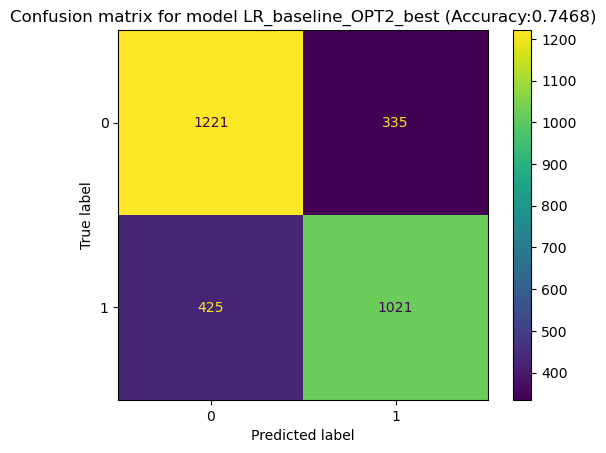

In [32]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_baseline_OPT2_best', y_test, predictions_opt2)])

In [33]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [34]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [35]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-09 21:53:14,686] A new study created in memory with name: no-name-6b727b89-9f7a-432a-8e03-0fe9d6647757
[I 2024-06-09 21:53:14,762] Trial 0 finished with value: 0.7468354430379747 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-09 21:53:14,834] Trial 1 finished with value: 0.7465023317788141 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 22.11232587253264, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-09 21:53:14,908] Trial 2 finished with value: 0.7465023317788141 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 39.25032222183842, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7468354430379747.
[I 2024-06-09 21:53:14,958] Trial 3 finished with value: 0.7418387741505663 and parameters: {'l1_ratio': 0.4119

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.7468354430379747


In [36]:
# Get best trials
trials_OTP3 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP3 = trials_OTP3.sort_values(by='value', ascending=False).head(10)
top_trials_OTP3

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.746835,2024-06-09 21:53:14.687312,2024-06-09 21:53:14.762504,0 days 00:00:00.075192,94.696791,0.517298,789,elasticnet,saga,COMPLETE
131,131,0.746835,2024-06-09 21:53:25.299893,2024-06-09 21:53:25.390395,0 days 00:00:00.090502,72.450796,0.465636,174,elasticnet,saga,COMPLETE
123,123,0.746835,2024-06-09 21:53:24.666099,2024-06-09 21:53:24.747844,0 days 00:00:00.081745,73.174067,0.633776,971,elasticnet,saga,COMPLETE
122,122,0.746835,2024-06-09 21:53:24.585923,2024-06-09 21:53:24.665180,0 days 00:00:00.079257,81.960295,0.599599,289,elasticnet,saga,COMPLETE
119,119,0.746835,2024-06-09 21:53:24.369946,2024-06-09 21:53:24.444829,0 days 00:00:00.074883,80.787934,0.219515,529,elasticnet,saga,COMPLETE
118,118,0.746835,2024-06-09 21:53:24.304348,2024-06-09 21:53:24.369235,0 days 00:00:00.064887,80.448712,0.227343,414,elasticnet,saga,COMPLETE
116,116,0.746835,2024-06-09 21:53:24.166839,2024-06-09 21:53:24.231825,0 days 00:00:00.064986,87.116476,0.194048,905,elasticnet,saga,COMPLETE
115,115,0.746835,2024-06-09 21:53:24.100001,2024-06-09 21:53:24.165117,0 days 00:00:00.065116,84.407829,0.395236,368,elasticnet,saga,COMPLETE
114,114,0.746835,2024-06-09 21:53:24.015782,2024-06-09 21:53:24.099130,0 days 00:00:00.083348,1.654734,0.794329,207,elasticnet,saga,COMPLETE
113,113,0.746835,2024-06-09 21:53:23.945254,2024-06-09 21:53:24.014912,0 days 00:00:00.069658,99.517332,0.086517,668,elasticnet,saga,COMPLETE


Metrics for LR_baseline_OPT3_best:
Accuracy: 0.7468
Weighted F1: 0.7463
Weighted Precision: 0.7472
Weighted Recall: 0.7468
Macro-Averaged Precision: 0.7474
Macro-Averaged Recall: 0.7454
F1: [0.76264834 0.72876517]
Precision: [0.7417983  0.75294985]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


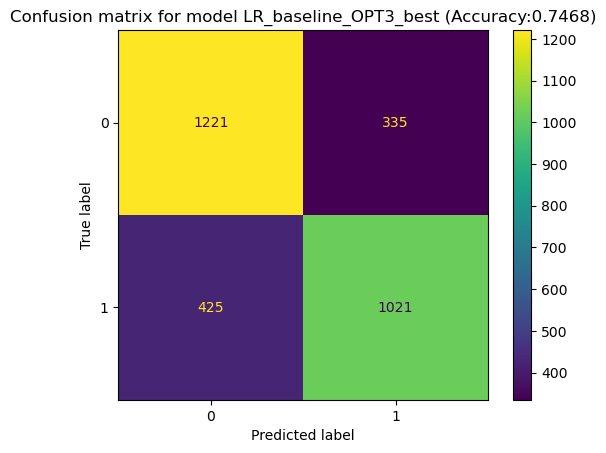

In [37]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_baseline_OPT3_best', y_test, predictions_opt3)])

end

In [38]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR_baseline_untuned,0.741839,0.741329,0.742131,0.741839,0.742311,0.740404,[0.75788816 0.72351052],[0.73738602 0.74723655]
LR_baseline_CV1_best,0.746835,0.746328,0.747170,0.746835,0.747374,0.745395,[0.76264834 0.72876517],[0.7417983 0.75294985]
LR_baseline_skf_best,0.746502,0.745986,0.746848,0.746502,0.747058,0.745049,[0.76241024 0.72831132],[0.74134791 0.75276753]
LR_baseline_OPT1_best,0.747502,0.746945,0.747927,0.747502,0.748170,0.745989,[0.76371571 0.72889843],[0.74152542 0.75481481]
LR_baseline_OPT2_best,0.746835,0.746328,0.747170,0.746835,0.747374,0.745395,[0.76264834 0.72876517],[0.7417983 0.75294985]
LR_baseline_OPT3_best,0.746835,0.746328,0.747170,0.746835,0.747374,0.745395,[0.76264834 0.72876517],[0.7417983 0.75294985]
